In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from numpy.linalg import svd as SVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import precision_score, accuracy_score, recall_score 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pickle
%matplotlib inline

In [18]:
reviews = pd.read_csv('../data/yelp.csv', index_col=0)
reviews.drop('business_neighborhoods', axis=1, inplace=True)
reviews = reviews[reviews['business_categories'].str.contains('Restaurant') == True]
no_rev = reviews[pd.isna(reviews['text']) == True].index 
reviews.drop(labels=no_rev, axis=0, inplace=True)
reviews = reviews.reset_index().drop('index', axis=1)

In [19]:
#im going to group 1-2 reatings and 4-5 ratings together
reviews['stars'] = reviews['stars'].apply(lambda x: 1 if x <= 2 else x)
reviews['stars'] = reviews['stars'].apply(lambda x : 2 if x == 3 else x)
reviews['stars'] = reviews['stars'].apply(lambda x: 3 if x >=4 else x)

#classification labels: 1 if rating <=2, 2 if rating == 3, 3 if rating >= 4

In [20]:
reviews['stars']

0         3
1         3
2         3
3         3
4         3
         ..
158419    1
158420    1
158421    1
158422    3
158423    2
Name: stars, Length: 158424, dtype: int64

In [44]:
def vectorize(df ,column, method='tfidf'):
        #takes in name of column to be cleaned, and method to vectorize
        lem = WordNetLemmatizer()
        #lemmatizing as opposed to stemming 
        s_words = stopwords.words('english')
        texts = []
        for doc in df[column].values:
            cleaned = [lem.lemmatize(word).lower() for word in doc.split(' ') \
                       if word not in s_words and word.isalpha() == True]
            #making sure that every word onl
            texts.append(' '.join(cleaned))
  
        if method == 'tfidf':
            vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
            vectorized = vectorizer.fit_transform(texts).toarray()
            return vectorized
            #creating a feature names attribute(bag of words)
        elif method == 'count':
            vectorizer = CountVectorizer(stop_words='english', max_features=5000)
            vectorized = vectorizer.fit_transform(self.documents).toarray()
            return vectorized
def scores(y_true, y_predict):
    precision = precision_score(y_true, y_predict,average='macro')
    accuracy = accuracy_score(y_true, y_predict)
    recall = recall_score(y_true, y_predict, average='macro')
    print(f'Precision : {precision} \n'  
          f'Accuracy : {accuracy} \n'
         f'Recall: {recall}')
    return [precision, accuracy, recall]

(0.0, 4.0)

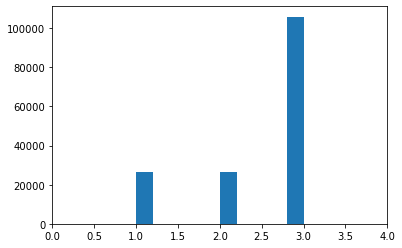

In [21]:
fig, ax = plt.subplots()
ax.hist(reviews['stars'], )
ax.set_xlim(0,4)

In [30]:
total = len(reviews)

In [27]:
class_1 = len(reviews[reviews['stars'] == 1])

In [28]:
class_2 = len(reviews[reviews['stars'] == 2])

In [29]:
class_3 = len(reviews[reviews['stars'] == 3])

In [31]:
class_1 / total

0.16604176134929052

In [32]:
class_3 / total


0.6681815886481847

In [33]:
class_2 / total

0.16577665000252487

In [37]:
pct = class_1 / class_3

In [39]:
under_sample = pct * class_3


In [75]:
len(test_x), len(test_X_train)

(118818, 39606)

In [76]:
df_train, df_holdout = train_test_split(reviews)

In [77]:
len(df_train), len(df_holdout)

(118818, 39606)

In [78]:
train_total = len(df_train)

train_class_a = len(df_train[df_train.stars ==1])
train_class_b = len(df_train[df_train.stars == 2])
train_class_c = len(df_train[df_train.stars == 3])
train_class_a, train_class_b, train_class_c, train_total

(19698, 19678, 79442, 118818)

In [79]:
samp_pct = train_class_a / train_class_c
samp_num = samp_pct * train_class_c

In [80]:
samp_num

19698.0

In [59]:
train_class_a

19717

In [66]:
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )

In [82]:
df_train = downsample(df_train, 'stars')

In [83]:
#checking to see class balanced
train_total = len(df_train)

train_class_a = len(df_train[df_train.stars ==1])
train_class_b = len(df_train[df_train.stars == 2])
train_class_c = len(df_train[df_train.stars == 3])
train_class_a, train_class_b, train_class_c, train_total

(19678, 19678, 19678, 59034)

In [85]:
#now i can split into X and y and vectorize 
X = vectorize(df_train, 'text')
y = df_train['stars'].values

In [86]:
X_holdout = vectorize(downsample(df_holdout, 'stars'), 'text')
y_holdout = downsample(df_holdout, 'stars')['stars'].values

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [87]:
baseline_y = []
for i in range(len(y)):
    baseline_y.append(np.random.choice([1, 2, 3]))


In [88]:
baseline_scores = scores(baseline_y, y)

Precision : 0.33434969678490356 
Accuracy : 0.3343496967849036 
Recall: 0.33435393846553163


In [94]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [95]:
log_model = LogisticRegression().fit(X_train, y_train)
log_hat = log_model.predict(X_test)
scores(y_test, log_hat)

/Users/user/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision : 0.6557526341989429 
Accuracy : 0.6581069178128599 
Recall: 0.6585519455143973


[0.6557526341989429, 0.6581069178128599, 0.6585519455143973]

In [96]:
final_log_hat = log_model.predict(X_holdout)
final_log_scores = scores(y_holdout, final_log_hat)


Precision : 0.3249220082442952 
Accuracy : 0.3231080739053404 
Recall: 0.3231080739053404


In [97]:
rm_model = RandomForestClassifier(max_samples=.5).fit(X_train, y_train)

In [99]:
rm_hat = rm_model.predict(X_test)
scores(y_test, rm_hat)

Precision : 0.601446622465564 
Accuracy : 0.6052578087946338 
Recall: 0.6057401528144193


[0.601446622465564, 0.6052578087946338, 0.6057401528144193]

In [100]:
final_rm_hat = rm_model.predict(X_holdout)
final_rm_scores = scores(y_holdout, final_rm_hat)

Precision : 0.33992441442520765 
Accuracy : 0.34325487218425715 
Recall: 0.34325487218425715


In [101]:
gb_model = GradientBoostingClassifier().fit(X_train, y_train)

In [102]:
pickle.dump(gb_model, open('gb_model.pkl', 'wb'))

In [103]:
gb_hat = gb_model.predict(X_test)
scores(y_test, gb_hat)

Precision : 0.5978838049919876 
Accuracy : 0.5984822819974253 
Recall: 0.5987978263997074


[0.5978838049919876, 0.5984822819974253, 0.5987978263997074]

In [104]:
final_gb_hat = gb_model.predict(X_holdout)
gb_scores = scores(y_holdout, final_gb_hat)

Precision : 0.34852014496502187 
Accuracy : 0.3393065046823589 
Recall: 0.3393065046823589


In [ ]:
#model not getting any better - when i should maybe think about lda? 
